In [1]:
import numpy as np
import pandas as pd
import os
import glob
import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.init as init
from torch.optim import Adam, SGD
from torch.autograd import Variable
from torch.utils.data import DataLoader, TensorDataset
from torch.utils.data import sampler

import torchvision.datasets as dset
import torchvision.transforms as T
import torch.nn.functional as F
eps = np.finfo(float).eps

import tqdm

plt.rcParams['figure.figsize'] = 10, 10
%matplotlib inline
sns.set()

%load_ext autoreload
%autoreload 2

In [2]:
use_cuda = True
use_cuda = use_cuda and torch.cuda.is_available()

In [3]:
dataloader_train = DataLoader(dset.MNIST('data', train=True, download=True, transform=T.ToTensor()),
                     batch_size=128, shuffle=True, num_workers=1, pin_memory=True)
dataloader_val = DataLoader(dset.MNIST('data', train=False, download=True, transform=T.ToTensor()),
                     batch_size=128, shuffle=False, num_workers=1, pin_memory=True)

In [4]:
def train_validate(model, dataloader, optim, loss_fn, train):
    model.train() if train else model.eval()
    total_loss = 0
    for batch_idx, (x, _ )in enumerate(dataloader):
        x = x.cuda() if use_cuda else x
        target = (x.data[:, 0] * 255).long()
        x_hat = model(x)
        loss = loss_fn(x_hat, target)
        if train:
            optim.zero_grad()
            loss.backward()
            optim.step()

        total_loss += loss.item()
    return total_loss / len(dataloader.dataset)


def init_weights(module):
    for m in module.modules():
        if isinstance(m, nn.Linear) or isinstance(m, nn.ConvTranspose2d):
            init.xavier_normal_(m.weight.data)
            if hasattr(m, 'bias') and m.bias is not None:
                init.constant_(m.bias, 0.0)
        elif isinstance(m, nn.Sequential):
            for sub_mod in m:
                init_weights(sub_mod)

In [25]:
class MaskedConv2d(nn.Conv2d):
    
    def __init__(self, mask_type, *args, **kwargs):
        super(MaskedConv2d, self).__init__(*args, **kwargs)
        self.mask_type = mask_type
        self.register_buffer('mask', self.weight.data.clone())
        _, _, kernel_height, kernel_width = self.weight.size()
        self.mask.fill_(0)
        half_h, half_w = kernel_height // 2, kernel_width // 2
    
        self.mask[:, :, :half_h, :] = 1.0
        self.mask[:, :, half_h, :half_w] = 1.0
        if self.mask_type == 'A':
            self.mask[:, :, half_h, half_w] = 0.0
        else:
            self.mask[:, :, half_h, half_w] = 1.0
        
    def forward(self, x):
        self.weight.data *= self.mask
        return super(MaskedConv2d, self).forward(x)

    
class MaskedNet(nn.Module):
    def __init__(self, n_layers, n_filters):
        super(MaskedNet, self).__init__()
        self.n_layers = n_layers
        self.n_filters = n_filters
        self.hs = [self.n_filters] * self.n_layers
        
        self.network = []
        self.network.extend([
                            MaskedConv2d('A', 1, self.n_filters, 7, 1, 3, bias=False),
                            nn.BatchNorm2d(self.n_filters),
                            nn.ReLU(True)
                            ])
        
        for in_feat, out_feat in zip(self.hs, self.hs[1:]):
            self.network.extend([
                            MaskedConv2d('B', in_feat, out_feat, 7, 1, 3, bias=False),
                            nn.BatchNorm2d(out_feat),
                            nn.ReLU(True)
                            ])
        
        self.network.extend([nn.Conv2d(self.n_filters, 256, 1)])
        self.network = nn.Sequential(*self.network)
    
#         mask_layers = [l for l in self.network.modules() if isinstance(l, MaskedConv2d)]
#         for layer in mask_layers:
#             print(layer.mask_type)
    
    def forward(self, x):
        return self.network(x)

In [26]:
fm = 64
model = MaskedNet(8, 64)
model = model.cuda() if use_cuda else model

# if torch.cuda.device_count() > 1 and use_cuda:
#     print("vroem vroem")
#     model = nn.DataParallel(model)

model.apply(init_weights)

optim = torch.optim.Adam(model.parameters(), 1e-3, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optim, step_size=45, gamma=0.1)

loss_fn = F.cross_entropy
n_epochs = 30

train_loss = []
val_loss = []
for epoch in tqdm.tqdm_notebook(range(0, n_epochs)):
    scheduler.step(epoch)
    t_loss = train_validate(model, dataloader_train, optim, loss_fn, train=True)
    train_loss.append(t_loss)

    if epoch % 5 == 0:
        v_loss = train_validate(model, dataloader_val, optim, loss_fn, train=False)
        val_loss.append(v_loss)
        
    

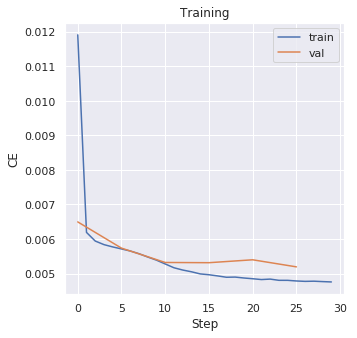

In [27]:
sns.set()
plt.rcParams['figure.figsize'] = 5, 5
plt.plot(np.arange(len(train_loss)), train_loss, label='train')
plt.plot(np.arange(0, len(val_loss) * 5, 5), val_loss, label='val')
plt.title('Training')
plt.xlabel('Step')
plt.ylabel('CE')
plt.legend()
plt.grid(True)

In [36]:
grid = torch.Tensor(144, 1, 28, 28)
grid.fill_(0)

grid = grid.cuda() if use_cuda else grid

model.eval()
for i in range(28):
    for j in range(28):
        out = model(grid)
        probs = F.softmax(out[:, :, i, j], dim=1)
        grid[:, :, i, j] = torch.multinomial(probs, 1).float() / 255.
        
im_grid = grid.cpu().detach().numpy()

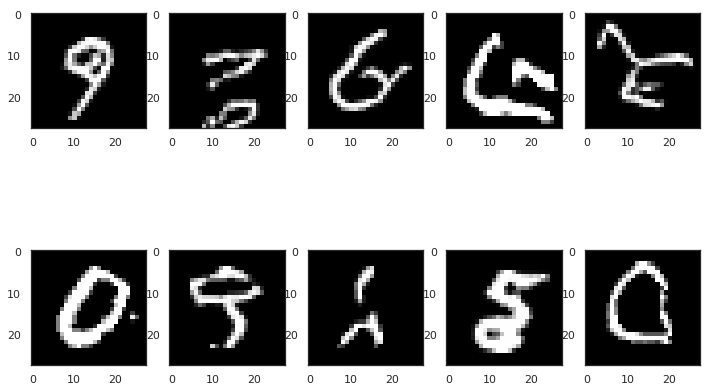

In [37]:
plt.rcParams['figure.figsize'] = 12, 8
with sns.axes_style('white'):
    fig, axis = plt.subplots(nrows=2, ncols=5)
    for i in range(10):
        axis[(i >= 5) * 1, i % 5].imshow(im_grid[i, 0, :, :].reshape(28, 28), cmap='gray')
plt.show()